<a href="https://colab.research.google.com/github/A380586/Cars_v_Jets/blob/main/Cars_vs_jets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries


In [170]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from PIL import Image

# import dataset

In [171]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [172]:
img_height = 180
img_width = 180
batch_size = 100

In [173]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'gdrive/MyDrive/Advanced coding/Datasets',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  'gdrive/MyDrive/Advanced coding/Datasets',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 96 files belonging to 2 classes.
Using 77 files for training.
Found 96 files belonging to 2 classes.
Using 19 files for validation.


In [174]:
os.listdir  ('gdrive/MyDrive/Advanced coding/Datasets')


['Jet', 'Car']

# Display dataset

In [175]:
class_names = train_ds.class_names
print(class_names)

['Car', 'Jet']


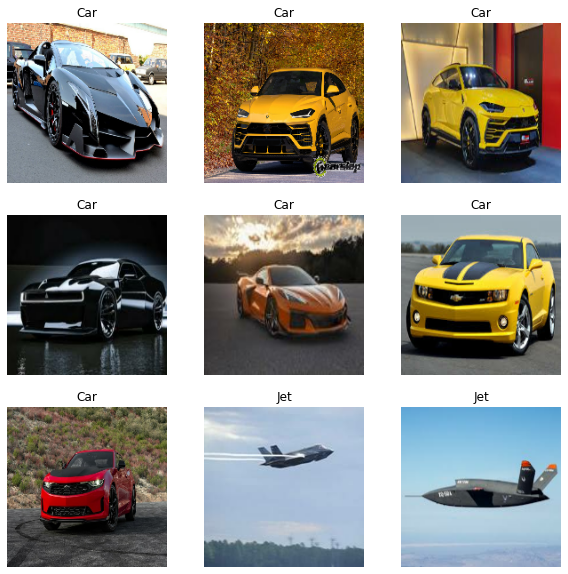

In [176]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Preprocessing

In [177]:
# Defining a few hyperparameters
# IMG_SIZE = 300
# batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE


# We can define the Resizing and Rescaling
resize_and_rescale = tf.keras.Sequential([
  # tf.keras.layers.experimental.preprocessing.Resizing(img_height, img_width),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
])

# A function that resizes, rescales, batches and shuffles
def prepare_images(ds, shuffle=False,):
  
  # Resize and rescale the dataset.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=AUTOTUNE)

  # Shuffles the dataset
  if shuffle:
    ds = ds.shuffle(1000)
  
  # Batch all datasets.
  # ds = ds.batch(batch_size)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [178]:
## Let us resize and rescale the images in our dataset
train_ds = prepare_images(train_ds, shuffle=True)
val_ds = prepare_images(val_ds)

In [179]:
#info about the images in the dataset
for x,y in train_ds.take(4):
  print(x.shape,y.shape)

(77, 180, 180, 3) (77,)


# Inference Function

In [180]:
def inference_function(image_path):
  """
  image_path (str): path of the image file

  returns index, probability
  img (PIL.Image.Image): the image from the image_path
  index (int): the class the image belongs to
  probability (float): the probability for that class
  """

  img = tf.keras.utils.load_img(
      image_path, target_size=(img_height,img_width) # MODIFY IMAGE HEIGHT AND WIDTH
  )

  # convert the img to an array. Refer to documentation: https://www.tensorflow.org/api_docs/python/tf/keras/utils/img_to_array
  img_array = tf.keras.utils.img_to_array( #mycode
    img, data_format=None, dtype=None
  )

  # apply your rescaling preprocessing step
  img_array = img_array*(1./255)

  # create a batch
  img_array = tf.expand_dims(img_array, 0)

  # run the img_array through your model. Hint: use the model.predict() function
  predictions = model.predict(img_array) #mycode

  # remove batch
  pred = np.squeeze(predictions)
  
  # index of the highest probability element of pred array. 
  # Hint 1: use argmax function: https://numpy.org/doc/stable/reference/generated/numpy.argmax.html
  # Hint 2: printing and seeing what the pred array looks like may help you
  index = np.argmax(pred) #mycode
  
  # highest probability in pred array
  probability = np.amax(pred) #mycode


  return img, index, probability

In [181]:
# run the inference function on your test image
img, class_index, class_probability = inference_function("download(37).jpg")
0.
("jpg")
# name of the class the image belongs to
class_name = class_names[class_index]

print(class_name, class_probability)
img

FileNotFoundError: ignored

### Transfer learning

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

In [ ]:
IMG_SIZE = 300
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

def prepare(ds, shuffle=False, augment=False):

  # Resize and rescale all datasets
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # # Batch all datasets
  # ds = ds.batch(batch_size)

  # preprocess for VGG16
  ds = ds.map(lambda x, y: (preprocess_input(x), y), 
              num_parallel_calls=AUTOTUNE)

  # Use buffered prefecting on all datasets
  return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)

In [ ]:
inception = tf.keras.applications.InceptionV3(include_top=False)
# model = tf.keras.applications.InceptionV3(include_top=False,
#                                                 weights='imagenet')

for layer in inception.layers:
    layer.trainable = False

model = tf.keras.models.Sequential([
    inception,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(2)
])
  
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

In [ ]:
# Early Stopping callback
ES = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights='True'
)

# train the model
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[ES]
)